In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Polling

Every computer needs to do I/O.

Suppose that our serial port has a baud rate of 9600 bit/s = 1200 bytes/sec.

Now, we have a sensor attached to the port, and our system wish to know if the sensor is sending any output.
Since one byte of data arrives every $1/1200 \approx 0.83ms$, and suppose that it takes $100ns$ to read the sensor's register, then we would take $0.83ms / 100ns = 8300$ read operations just to detect if the sensor sent any data.

This is horribly inefficient because we only need to know the presence/absence of data once every 0.83ms, but we are spending so many operations just to monitor the serial port.

A parallel to this would be the below Python code:

In [3]:
import threading
import time

register = None
num_reads = 0
is_complete = False


def send_byte():
    global register
    print("sending data")
    register = 42


def complete():
    global is_complete
    is_complete = True


def do_work(value):
    print(f"Received {value} from device")


def poll():
    global num_reads, register
    num_reads += 1
    value = register
    register = None
    return value


def main():
    # Do other work

    if val := poll():
        do_work(val)


threading.Timer(1, send_byte).start()
threading.Timer(2, complete).start()

while not is_complete:
    main()

print(f"Polled {num_reads} times")

sending data
Received 42 from device
Polled 7150243 times


Graphically, it would be:

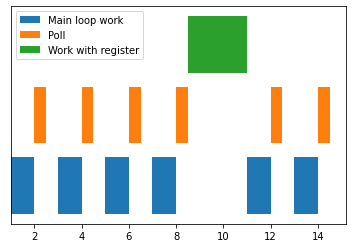

In [4]:
plt.barh(y=1, width=1, left=[1, 3, 5, 7, 11, 13], label="Main loop work")
plt.barh(y=2, width=0.5, left=[2, 4, 6, 8, 12, 14], label="Poll")
plt.barh(y=3, width=2.5, left=8.5, label="Work with register")
plt.yticks([])
plt.legend()
plt.show()

Notice that we need to spend time polling for the device each time we run our main loop, even though the device is only ready at $t = 8.5$

# Interrupt 

Suppose that we allow the I/O device and the CPU to run concurrently.
After the device controller for the I/O device completes its I/O operations, it informs the CPU using an interrupt, so the CPU knows that the register is ready to be read.

It would look like below graphically.

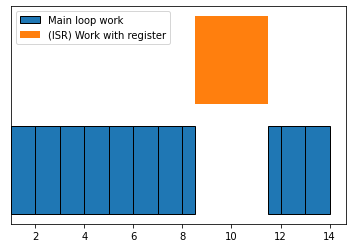

In [5]:
main_loops = np.hstack((np.arange(1, 9), 11.5, np.arange(12, 14)))
plt.barh(y=1, width=np.where((main_loops == 8.0) | (main_loops == 11.5),
         0.5, 1), left=main_loops, label="Main loop work", edgecolor='black')
plt.barh(y=2, width=3, left=8.5, label="(ISR) Work with register")
plt.yticks([])
plt.legend()
plt.show()

(Note that the interrupt is able interrupt the main process mid-loop, and resumes when the interrupt handler is complete, via a process called [preemption](task_management.ipynb#Preemptive-vs-non-preemptive))

(Also, the work on the register is taking slightly longer due to overhead of calling the ISR)

Using interrupt, we see that we no longer spend CPU cycles on checking the register, thus allows us to perform more work in the main loop.

A analogy would be polling is the CPU continually asking if the register is ready, while interrupts allows the device to tell the CPU that the register is ready.

Interrupts tells the CPU to run the **interrupt service routine (ISR)**.
The CPU holds an **interrupt vector** which maps interrupt request (IRQ) to its corresponding function to be ran.


| Event | IRQ | ISR | ISR address | 
| :---: | :---: | :---: | :---: |
| Mouse move | 1 | Move cursor | 0x14 | 
| Key press | 2 | Display typed character | 0x18 | 
| CPU overheat | 3 | Throttle CPU | 0x30 | 

A **trap** is a type of interrupt that is triggered by an error or user request.

## Types of interrupts

### Synchronous vs Asynchronous

Synchronous interrupts are exceptions raised by internal events, _ie_ they are caused by a processor's instruction, _eg_ division by 0.

Asynchronous interrupts are raised by external events, and thus are not aligned with processor's instructions, _eg_ key presses from keyboard, hardware timer.

## Interrupt response time

Interrupt response time = interrupt latency + processing time

**Interrupt latency**: The interval between time when the interrupt is raised and the time when ISR begins.
This is caused by the overhead of context switching to the ISR.

Suppose that we know that an specific interrupt can occur every $T$ ms.
Then we would require that our interrupt response time be $\leq T$ms, otherwise we won't be able to finish processing the previous handler when the next interrupt comes in, causing an accumulation of pending tasks and hence failing to meet our deadline.

## Handling multiple interrupts

If our system has multiple interrupt, it makes sense that some interrupts may be more important for others.
For example, the interrupt for handling key presses would be less important than the interrupt which reduces a CPU temperature in the case of overheating.
Hence it makes sense that interrupts have priorities, and higher priority interrupts can obtain control when the process is running the ISR of a lower priority one (but not vice versa).
When a lower priority interrupt is triggered while the CPU is processing the ISR of a higher priority one, it will be interrupted to perform the higher priority ISR, and resuming when that is done. 

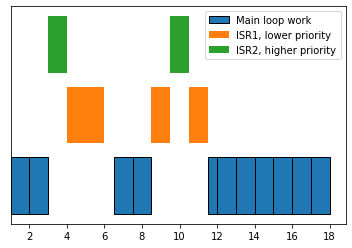

In [6]:
main_loops = np.hstack(
    (np.arange(1, 3), np.arange(6.5, 8.5), 11.5, np.arange(12, 18)))
plt.barh(y=1, width=np.where((main_loops == 8.0) | (main_loops == 11.5),
         0.5, 1), left=main_loops, label="Main loop work", edgecolor='black')
plt.barh(y=2, width=[2, 1, 1], left=[4, 8.5, 10.5],
         label="ISR1, lower priority")
plt.barh(y=3, width=1, left=[3, 9.5], label="ISR2, higher priority")
plt.yticks([])
plt.legend()
plt.show()

So for example, ISR2 is triggered at $t=3$, and ISR1 is triggered at $t=3.1$.
Hence, we ignore ISR1 until after ISR2 completes.

Then, at $t=8.5$, ISR1 is being processed, but at $t=9.5$, ISR2 is triggered.
Hence, our system jumped immediately to process ISR2, before resuming to ISR1.

Notice that because higher priority ISR can delay the processing of a lower priority ISR, the latency of the higher priority ISR contributes to the latency of the lower priority ones.
Hence, it is important to **minimize the amount of work in an ISR**, to ensure that its own deadline (and the deadlines of interrupts of lower priorities) are met.

So in our previous example, if the deadline of ISR1 is 2.5 units after the interrupt is sent, then our system will fail to meet the deadline, because the interrupt was sent at $t=3.1$, but the ISR1 is completed at $t=6$, which meant it took $2.9$ units.
This was because we were delayed further by the higher priority ISR.

## Interrupts for I/O

Suppose that our system is reading a file from storage into RAM.
If we were to use interrupt, then an interrupt will be triggered for every bytes transferred.
This is inefficient because the CPU only needs to know when the document is ready.

Hence, we introduce the concept of **direct memory access (DMA)**

### Direct memory access

The device controller will transfer blocks of data from storage directly to main memory.
Once a block of data is transferred, it will then send an interrupt to the CPU.
Hence, the interrupts occur per block, rather than per byte.

Note that there is also overhead in setting up the DMA controller, but it is usually worth it to reduce the CPU cycles that would have been used for interrupt handling.